In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer
from gensim.models import FastText
import umap.umap_ as umap

/Users/ruattar/fast_nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# стоп-слова для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1007)>


In [4]:
# Инициализация лемматизатора
morph = MorphAnalyzer()

def preprocess_text(text):
    """
    Предобработка текста:
    - Приведение к нижнему регистру
    - Удаление пунктуации, спецсимволов, чисел
    - Токенизация
    - Удаление стоп-слов
    - Лемматизация
    """
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации, спецсимволов, чисел
    text = re.sub(r'[^а-яё\s]', ' ', text)
    # Токенизация
    tokens = text.split()
    # Удаление стоп-слов и лемматизация
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    return tokens


def preprocess_text_v2(text):
    """
    Предобработка текста:
    - Приведение к нижнему регистру
    - Удаление пунктуации, спецсимволов, чисел
    - Токенизация
    - Удаление стоп-слов
    - Лемматизация
    """
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации, спецсимволов, чисел
    text = re.sub(r'[^а-яё\s]', ' ', text)
    # Токенизация
    tokens = text.split()
    # Удаление стоп-слов и лемматизация
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    return tokens

In [49]:
# # предобработка к колонке 'purpose'

# df = pd.read_csv('ml_data.csv')
# df['tokens'] = df['purpose'].astype(str).apply(preprocess_text)

In [5]:
df = pd.read_parquet('tokenized.parquet')

In [1]:
# df.head(1)

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_11172/2785307123.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')


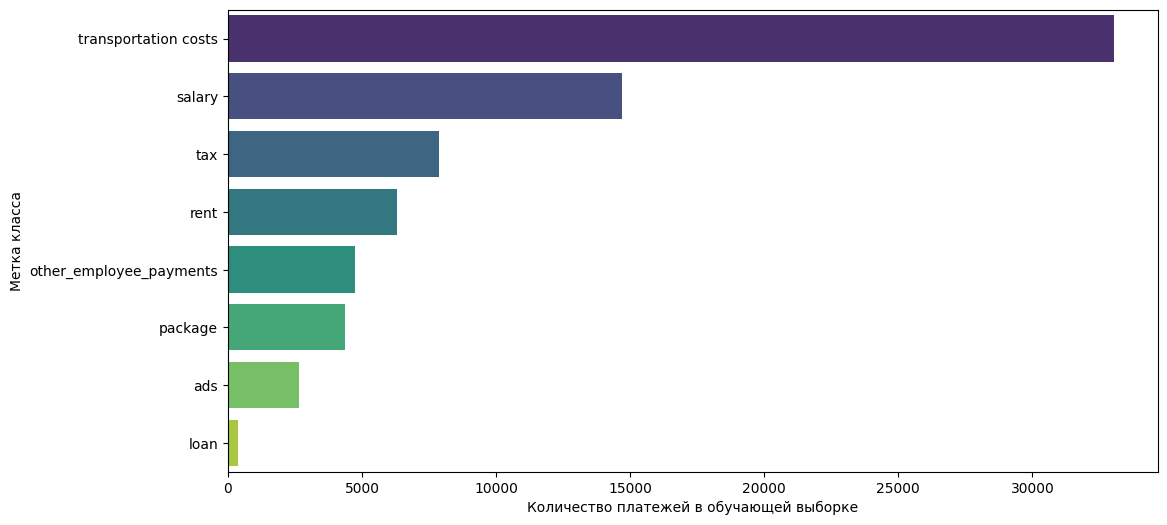

In [36]:
label_counts = df.query("label != 'other'").label.value_counts(normalize=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.xlabel('Количество платежей в обучающей выборке')
plt.ylabel('Метка класса')
plt.savefig('images/Universal_labels_dist.svg', format='svg')
plt.show()

In [7]:
# df.to_parquet('tokenized.parquet', index=False)

## Основные характеристики корпуса

Средняя длина текста: 9.23 слов
Медианная длина текста: 9.0 слов
Максимальная длина текста: 29 слов
Минимальная длина текста: 1 слов
Общее количество текстов: 171874


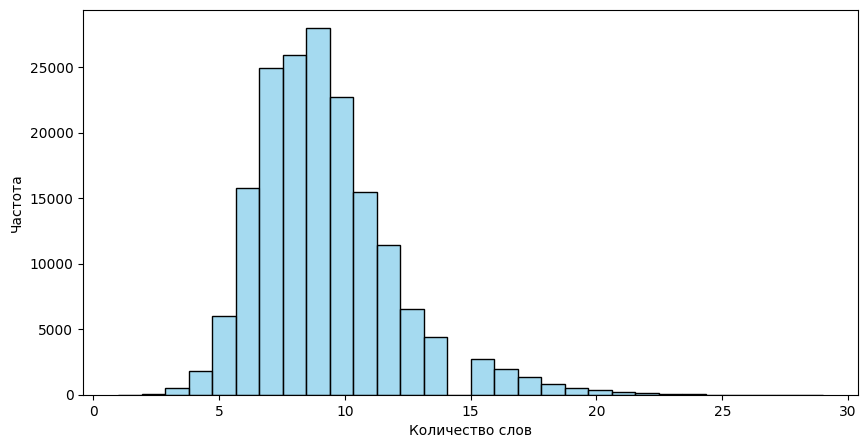

In [8]:
# Длина текстов (по количеству слов)
df['text_len'] = df['tokens'].apply(len)

# Гистограмма распределения длин текстов
plt.figure(figsize=(10, 5))
sns.histplot(df['text_len'], bins=30, kde=False, color='skyblue')
# plt.title('Распределение длин назначений платежа (по количеству слов)')
plt.xlabel('Количество слов')
plt.ylabel('Частота')

# Статистики по длинам текстов
mean_len = df['text_len'].mean()
median_len = df['text_len'].median()
max_len = df['text_len'].max()
min_len = df['text_len'].min()

print(f'Средняя длина текста: {mean_len:.2f} слов')
print(f'Медианная длина текста: {median_len} слов')
print(f'Максимальная длина текста: {max_len} слов')
print(f'Минимальная длина текста: {min_len} слов')
print(f'Общее количество текстов: {len(df)}')

plt.savefig("images/length_hist.svg", format='svg')
plt.show()

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_11172/2834235977.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


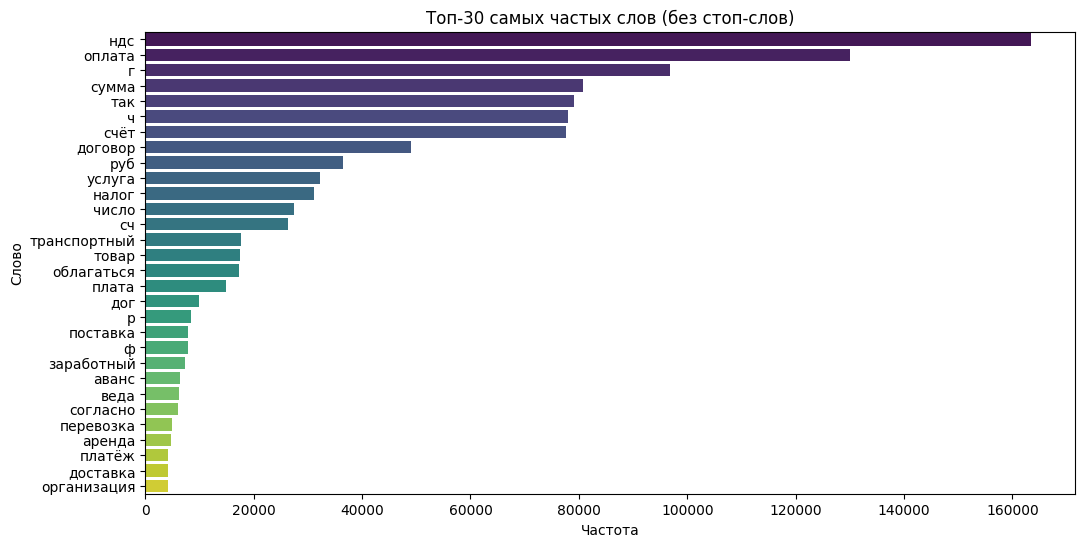

In [9]:
# Частотный анализ слов (без стоп-слов)
all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_counts = Counter(all_tokens)
top_words = word_counts.most_common(30)

# Barplot топ-30 слов
words, counts = zip(*top_words)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Топ-30 самых частых слов (без стоп-слов)')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.show()

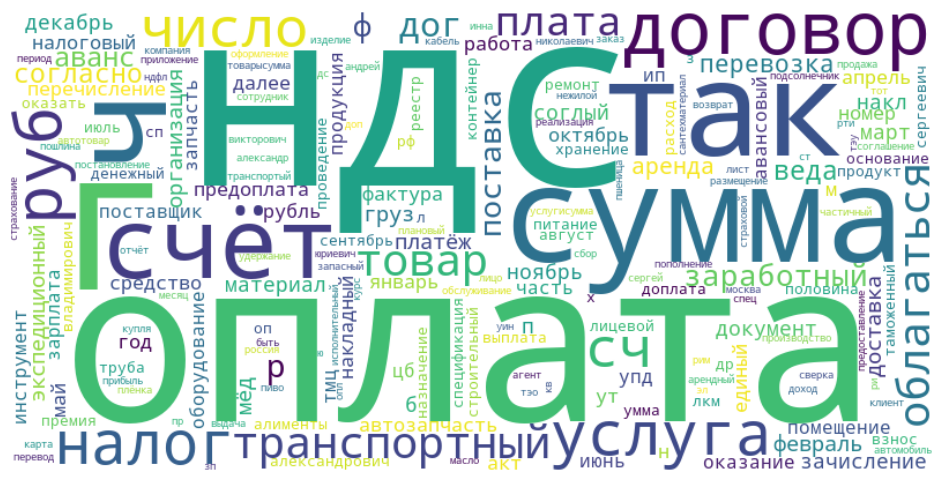

In [10]:
# Wordcloud по корпусу
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None, 
                      collocations=False).generate_from_frequencies(word_counts)

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
# ax.set_title('Облако слов по корпусу (без стоп-слов)')

fig.savefig('images/wordcloud.svg', format='svg')
plt.show()


Как раз даже беглым взглядом на облако можно заметить слова, отсылающие нас к упомянутым в первой главе коммерческим расходам (например, <<транспорт>>) и уплате налогов.

In [21]:
# --- 3. Визуализация топ-1000 слов через UMAP ---

# Отбираем топ-1000 слов
top_1000_words = [word for word, _ in word_counts.most_common(1000)]

# Обучаем FastText на корпусе токенов
# FastText ожидает список списков токенов
model = FastText(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4, sg=1, epochs=10)

In [ ]:

# Получаем эмбеддинги для топ-1000 слов
embeddings = np.array([model.wv[word] for word in top_1000_words])

# Снижаем размерность до 2D с помощью UMAP
umap_reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

In [ ]:
# Визуализация: scatter plot с подписями слов
plt.figure(figsize=(16, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.6)
for i, word in enumerate(top_1000_words):
    if i % 25 == 0:  # Подписываем только часть слов для читаемости
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], word, fontsize=8, alpha=0.7)
plt.title('UMAP-визуализация эмбеддингов топ-1000 слов корпуса')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True, alpha=0.3)
plt.savefig('images/UMAP.png', format='png')

Визуальный анализ позволяет выделить кластеры слов, относятщиеся к разным видам текущих расходов компаний из <<универсальных классов>> (вывоз, перевозка, проживание, полиэтилен и др.) и нескольким экономическим видам деятельности в части <<материальных расходов>> (спортивный, медицинский, концентрат, сантехматериал и др.)

In [22]:
print('\n--- Основные числовые метрики корпуса ---')
print(f'Всего текстов: {len(df)}')
print(f'Уникальных слов (без стоп-слов): {len(word_counts)}')
print(f'Средняя длина текста: {mean_len:.2f} слов')
print(f'Медианная длина текста: {median_len} слов')
print(f'Максимальная длина текста: {max_len} слов')
print(f'Топ-10 самых частых слов: {top_words[:10]}')



--- Основные числовые метрики корпуса ---
Всего текстов: 171874
Уникальных слов (без стоп-слов): 21947
Средняя длина текста: 9.23 слов
Медианная длина текста: 9.0 слов
Максимальная длина текста: 29 слов
Топ-10 самых частых слов: [('ндс', 163423), ('оплата', 130111), ('г', 96777), ('сумма', 80730), ('так', 79058), ('ч', 77964), ('счёт', 77717), ('договор', 49057), ('руб', 36552), ('услуга', 32279)]
